# <center> Assignment 4 - LMS Learning Rule for 4x4 Tic Tac Toe
###### Author: Rudraksh Kapil - 177154
In this notebook, we implement a machine learning program to play 5x5 Tic Tac Toe game, using the least means square learning rule.
    
##### Note: The code allows for boards of any size.

In [70]:
# import statements
import numpy as np
import pandas as pd
import copy
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

#### Board Initialisation

In [39]:
def board_init(size = 4):
    ''' 
        Function to initialise board.
        Input:
            - board size
        Output:
            - (size x size) matrix filled with '-', denoting blanks.
    '''
    
    board = np.ones((size,size), dtype = str)
    board[:,:] = '-'
    return board

#### Checking for winner

In [40]:
def determine_winner(board):
    '''
        Function to determine the winner of the game.
        Input: 
            - board state
        Output: 
            - 100 if X wins
            - (-100) if O wins
            - 0 if draw
    '''
    # determine size -> number of rows
    size = board.shape[0]
    
    
    ### check for rows and columns
    for i in range(size):
        if np.all(board[i,:] == 'X'): # 4 Xs in row i -> X
            return 100
        if np.all(board[i,:] == '0'): # 4 Os in row i -> O
            return -100
        if np.all(board[:,i] == 'X'): # 4 Xs in col i -> X
            return 100 
        if np.all(board[:,i] == 'O'): # 4 Os in col i -> O
            return -100
        

    ### check the two diagonals - set to false if other symbol encountered
    # leading => (top left to bottom right), trailing => [opposite]
    diagonal_checks = {
        'X_leading' : True, # leading diagonal has all Xs 
        'O_leading' : True, # leading diagonal has all Os
        'X_trailing': True, # trailing has all Xs
        'O_trailing': True  # trailing has all Os
    }
    
    # in each iter, if the value doesnt match, set to False
    for i in range(size):
        if board[i,i] != 'X':
            diagonal_checks['X_leading'] = False
        if board[i,i] != 'O':
            diagonal_checks['O_leading'] = False
        if board[i,(-i-1)] !=  'X':
            diagonal_checks['X_trailing'] = False
        if board[i,(-i-1)] !=  'O':
            diagonal_checks['O_trailing'] = False

    # check which one is remaining as true, if any
    if diagonal_checks['X_leading']: 
        return 100
    if diagonal_checks['X_trailing']: 
        return 100
    if diagonal_checks['O_leading']: 
        return -100
    if diagonal_checks['O_trailing']:
        return -100
    
    
    ### check if it was a draw
    if np.sum(board == '-') == 0:
        return 0
    
    # Otherwise not over
    return -1 

In [41]:
weights = np.random.randn(33)/10

#### Extracting features

In [42]:
def extract_features(board):
    '''
        Function to extract the (size*8 + 1) features from the board
        Input: 
            - board
        Output:
            - Feature vector of length (size*8+1)
                * 1 is for the bias
                * for each n of {1 to size}, we have the following 8 features: -> total size*8
                    - number of rows with n Xs
                    - number of rows with n Os
                    - number of cols with n Xs
                    - number of cols with n Os
                    - if leading diagonal has n Xs
                    - if leading diagonal has n Os
                    - if trailing diagonal has n Xs
                    - if trailing diagonal has n Os
    '''
    
    # get size and create feature vector using it
    size = board.shape[0]
    feature_vector = np.zeros(size*8 + 1, dtype=np.float64)
    
    # bias
    feature_vector[0] = 1.0
    
    # calculate the number of Xs, Os, and -s in rows and columns
    num_x_row   = np.count_nonzero(board == 'X', axis = 1)
    num_x_col   = np.count_nonzero(board == 'X', axis = 0)
    num_o_row   = np.count_nonzero(board == 'O', axis = 1)
    num_o_col   = np.count_nonzero(board == 'O', axis = 0)
    num_emp_row = np.count_nonzero(board == '-', axis = 1)
    num_emp_col = np.count_nonzero(board == '-', axis = 0)
    
    # diagonal counters
    leading_X = 0      # Xs in leading
    leading_O = 0      # Os in leading
    leading_emp = 0    # -s in leading
    trailing_X = 0     # Xs in trailing
    trailing_O = 0     # Os in trailing
    trailing_emp = 0   # -s in trailing
    
    for i in range(size):
        if board[i,i] == 'X':
            leading_X += 1
        if board[i,i] == 'O':
            leading_O += 1
        if board[i,i] == '-':
            leading_emp += 1
        if board[i,-i-1] == 'X':
            trailing_X += 1
        if board[i,-i-1] == 'O':
            trailing_O += 1
        if board[i,-i-1] == '-':
            trailing_emp += 1
    
    
    # populate feature vector
    for i in range(1,size+1): # for each n of {1 to size}
        # for each row/col -> in first 4 of 8 positions
        for j in range(size): 
            
            if num_x_row[j] == i and num_emp_row[j] == size-i:
                feature_vector[(i-1)*8 + 1] += 1
            if num_x_col[j] == i and num_emp_col[j] == size-i:
                feature_vector[(i-1)*8 + 2] += 1
            if num_o_row[j] == i and num_emp_row[j] == size-i:
                feature_vector[(i-1)*8 + 3] += 1
            if num_o_col[j] == i and num_emp_col[j] == size-i:
                feature_vector[(i-1)*8 + 4] += 1
              
        # diagonals -> in next 4 positions
        if leading_X == i and leading_emp == size-i :
            feature_vector[(i-1)*8 + 5]+=1
        if trailing_X == i and trailing_emp == size-i :
            feature_vector[(i-1)*8 + 6]+=1
        if leading_O == i and leading_emp == size-i :
            feature_vector[(i-1)*8 + 7]+=1
        if trailing_O == i and trailing_emp == size-i :
            feature_vector[(i-1)*8 + 8]+=1
      
    # return
    return feature_vector

#### Determine next possible moves

In [43]:
def get_possible_states(board, player):
    '''
        Function to determine the next possible moves from the current.
        Input:
            - board 
            - current player
        Output:
            - array of next possible board_states
    '''
    # array to return
    board_states = []
    
    # get size
    size = board.shape[0]
    
    # go through each cell
    for i in range(size):
        for j in range(size):
            # if cell is empty, we can make a move here
            if board[i,j] == '-':
                # make a copy, set value, and add to the possible states
                temp_board = copy.deepcopy(board)
                temp_board[i,j] = player
                board_states.append(temp_board)
                
    # return the next possible board_states
    return board_states

#### Get the value of the given board

In [44]:
def calculate_board_value(board):
    '''
        Function to calculate the value of a given board
        from the learned function
        Input:
            - board 
        Output:
            - the value of the learned function for the board
    '''
    # extract features and calculate value = w.dot(feature_vector.T)
    feature_vector = extract_features(board)
    board_value = np.dot(weights,feature_vector.T)
    
    # return output
    return board_value

In [45]:
def calculate_board_value_multiple(boards):
    '''
        Function to calculate the value of a given board(s)
        from the learned function
        Input:
            - boards -> array of boards
        Output:
            - array of the value of the learned function for the boards.
    '''
    board_values = []
    
    for board in boards:
        # extract features and calculate value = w.dot(feature_vector.T)
        feature_vector = extract_features(board)
        board_value = np.dot(weights,feature_vector.T)
        board_values.append(board_value)
    
    # return output
    return board_values

#### Printing Board

In [46]:
def print_board(board):
    ''' 
        Prints board in correct format
        Input:
            - board state
    '''
    # get size
    size = board.shape[0]
    
    # loop to print
    print("+",end='')
    for j in range(size):
        print('---', end = '+')
    for i in range(size):
        print("\n| ", end='')
        for j in range(size):
            print(board[i,j], end = ' | ')
        print("\n+",end='')
        for j in range(size):
            print('---', end = '+')
    print("")

#### Training function

In [50]:
def train(size, alpha, num_iters):
    '''
        Function to carry out training of our program.
        Inputs: 
            - size of board
            - alpha    (learning rate)
            - num_iters (number of iterations)
    '''
    
    # loop for num_iters 
    for epoch in tqdm(range(num_iters)):

        # current board history
        curr_board_history = []
        
        # initialise board and current token
        board = board_init(size)
        current = 'X'
        
        # until game isn't over
        while (determine_winner(board) == -1):
            
            # get next possible states, and calculate their values
            next_states = np.array(get_possible_states(board, current))
            np.random.shuffle(next_states)
            next_values = calculate_board_value_multiple(next_states)
            
            # append board to history and set the next board state as the one with maximum value
            curr_board_history.append(board)
            board = next_states[np.argmax(next_values)]
              
            # toggle move -> for training, we randomly toggle this
            # otherwise it always ends in a draw and weights never change
            rand_val = np.random.randn(1)
            if (rand_val > 0):
                current = 'X' if (current == 'O') else 'O'
            
        #print(determine_winner(board))
        #print_board(board)
        
            
        # append final board, and determine winner
        curr_board_history.append(board)
        result = determine_winner(board)
        
        # update weights
        global weights
        for idx, board_state in enumerate(curr_board_history):
            X = extract_features(board_state)
            if ((idx+2) < len(curr_board_history)):
                weights += alpha * (calculate_board_value(curr_board_history[idx+2]) 
                              - calculate_board_value(board_state))* X
            else:
                weights += alpha * (result - calculate_board_value(board_state)) * X
    

In [64]:
# hyperparameters
size = 5
alpha = 0.05
num_iters = 1000
num_features = size*8 + 1

# initialise random weights
weights = np.random.randn(num_features) / 10
weights_copy = copy.deepcopy(weights)         # for visualisation afterwards

# call the training function
train(size, alpha, num_iters)

100%|██████████| 1000/1000 [01:06<00:00, 14.95it/s]


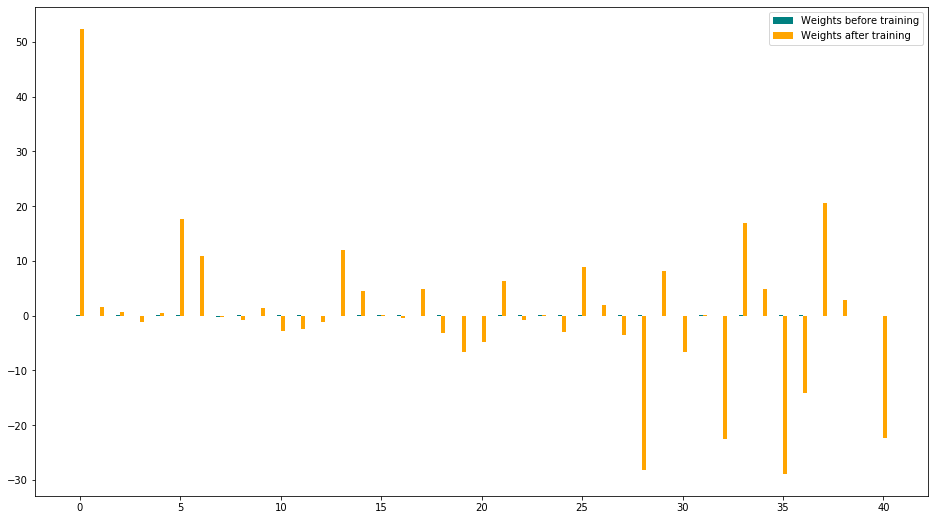

In [78]:
# plot difference in weights
plt.figure(figsize=(16,9))
x = np.arange(num_features)
ax = plt.subplot(111)
ax.bar(x-0.1, (weights_copy), width=0.2, color = 'teal', label='Weights before training')
ax.bar(x+0.1, (weights), width=0.2, color = 'orange', label='Weights after training')
ax.legend()
plt.show()

#### Test Function

In [80]:
def play(size):
    '''
        Allows human player to play against trained program
        After training, the program will play optimally, making it essentially impossible to defeat
    '''
    # initialise board
    board = board_init(size)
    
    # signifies whose turn it currently is
    current = 'X'
    
    # loop while game is not over
    while (determine_winner(board) == -1):
        
        if current == 'X':
            print('Computer\'s move...')
            
            # get next possible states, and calculate their values
            next_states = np.array(get_possible_states(board, current))
            next_values = calculate_board_value_multiple(next_states)
            
            # set the next board state as the one with maximum value
            board = next_states[np.argmax(next_values)]
            
            # print board
            print_board(board)
            
        else:
            print('Player\'s move')
            
            # get input move
            print('Enter x and y coordinates (0 indexed, sperated by \'enter\'): -1 to quit')
            while (True): 
                try: 
                    a = int(input())
                    b = int(input())
                    
                    if (a == '-1' or b == '-1'):
                        return
                    
                    if board[a,b] == '-':
                        break    
                    else:
                        print("Please select an open position. Try again.")
                        
                except:
                    print("Invalid input! Try again.")
            
            # mark an O and print the board
            board[a,b] = 'O'
            print_board(board)
    
        # toggle move
        current = 'X' if (current == 'O') else 'O'
    
    # determine winner and print output
    result = determine_winner(board)
    print("\n-------Result:--------\n")
    if result == 100: 
        print('Computer Wins :)')
    elif result == -100:
        print('Player Wins :(')
    else:
        print('Draw :|')

In [81]:
# call the play function to test our program
play(size)

Computer's move...
+---+---+---+---+---+
| - | - | - | - | - | 
+---+---+---+---+---+
| - | - | - | - | - | 
+---+---+---+---+---+
| - | - | X | - | - | 
+---+---+---+---+---+
| - | - | - | - | - | 
+---+---+---+---+---+
| - | - | - | - | - | 
+---+---+---+---+---+
Player's move
Enter x and y coordinates (0 indexed, sperated by 'enter'): -1 to quit
0
0
+---+---+---+---+---+
| O | - | - | - | - | 
+---+---+---+---+---+
| - | - | - | - | - | 
+---+---+---+---+---+
| - | - | X | - | - | 
+---+---+---+---+---+
| - | - | - | - | - | 
+---+---+---+---+---+
| - | - | - | - | - | 
+---+---+---+---+---+
Computer's move...
+---+---+---+---+---+
| O | - | - | - | - | 
+---+---+---+---+---+
| - | X | - | - | - | 
+---+---+---+---+---+
| - | - | X | - | - | 
+---+---+---+---+---+
| - | - | - | - | - | 
+---+---+---+---+---+
| - | - | - | - | - | 
+---+---+---+---+---+
Player's move
Enter x and y coordinates (0 indexed, sperated by 'enter'): -1 to quit
0
1
+---+---+---+---+---+
| O | O | - | - | - |

You can see from the game above that both players (me and the program) were playing optimally, hence it resulted in a draw. In certain places, especially in the first few moves, you can clearly see the program making moves that stop me from winning. Thus, the program has been correctly trained on this task. 

###### <center> END OF ASSIGNMENT <br><br> Author: Rudraksh Kapil - 177154 <br><br> Thank you for reading :)